In [1]:
import jax.numpy as jnp
from jax import jit, grad, jvp, random
from jax.scipy.stats import multivariate_normal as mvn
from jax.scipy.stats import norm

from scipy.optimize import minimize, NonlinearConstraint
from itertools import product

from jax.config import config
config.update('jax_enable_x64', True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("poster", "darkgrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,12)

from optispd.manifold import SPD, Product, Euclidean
from optispd.minimizer import minimizer

In [2]:
n = 1000
p = 2
tol = 1e-6
seed = 0
rng = random.PRNGKey(seed)

In [3]:
def compute_delta(sl, cor):
    bilin = jnp.einsum('i,ij,j', sl, cor, sl)
    return jnp.matmul(cor, sl) / jnp.sqrt(1 + bilin)

def compute_omega(cor, sl):
    delta = compute_delta(sl, cor)
    omega = jnp.append(
        jnp.append(cor, jnp.expand_dims(delta, 1), axis=1),
        jnp.expand_dims(jnp.append(delta, 1.), 0),
        axis=0
    )
    return omega

def sample_skew(key, loc, cov, sl, shape=(1,)):
    p = loc.shape[-1]
    scale = jnp.sqrt(jnp.diag(cov))
    cor = jnp.einsum('i,ij,j->ij', 1./scale, cov, 1./scale)
    omega = compute_omega(cor, sl)
    X = random.multivariate_normal(
        key=key, shape=shape,
        mean=jnp.zeros(shape=(p + 1),),
        cov=omega,
        )
    X0 = jnp.expand_dims(X[:, -1], 1)
    X = X[:, :-1]
    Z = jnp.where(X0 > 0, X, - X)
    return loc + jnp.einsum('i,ji->ji', scale, Z)

def capital_phi(alpha, y):
    return jnp.sum(norm.logcdf(jnp.matmul(alpha, y)))

def small_phi(cov, y):
    mean = jnp.zeros(shape=(cov.shape[-1],))
    return jnp.sum(mvn.logpdf(y, mean=mean, cov=cov))

def loglik_skew(cov, slant, data):
    scale = jnp.sqrt(jnp.diag(cov))
    al = jnp.einsum('i,i->i', 1./scale, slant)
    Phi = capital_phi(al, data.T)
    phi = small_phi(cov, data)
    return 2 + phi + Phi

def pdf_skew(y, cov, slant):
    scale = jnp.sqrt(jnp.diag(cov))
    al = jnp.einsum('i,i->i', 1./scale, slant)
    Phi = norm.logcdf(jnp.matmul(al, y.T))
    phi = mvn.logpdf(y, mean=jnp.zeros_like(slant), cov=cov)
    return jnp.exp(2 + phi + Phi)

In [4]:
rng, *key = random.split(rng, 3)

tmean = jnp.zeros(shape=(p,))

tcov = random.normal(key[0], shape=(p, p))
tcov = jnp.matmul(tcov, tcov.T)

tslant = random.uniform(key[1], shape=(p,), maxval=5)

print("True values:")
print("\tMean: {}".format(tmean))
print("\tSigma: {} (Eigs: {})".format(tcov.ravel(), jnp.linalg.eigvalsh(tcov)))
print("\tSkew: {}".format(tslant))

True values:
	Mean: [0. 0.]
	Sigma: [4.27065481 1.21378081 1.21378081 1.53117271] (Eigs: [1.07076229 4.73106523])
	Skew: [2.72181592 1.29104493]


In [5]:
rng, key = random.split(rng)
data = sample_skew(key, tmean, tcov, tslant, shape=(n,))

nloglik = jit(lambda x, y: - loglik_skew(x, y, data))

true_loglik = nloglik(tcov, tslant)
print("\tLoglik: {:.2f}".format(true_loglik))

	Loglik: 3809.62


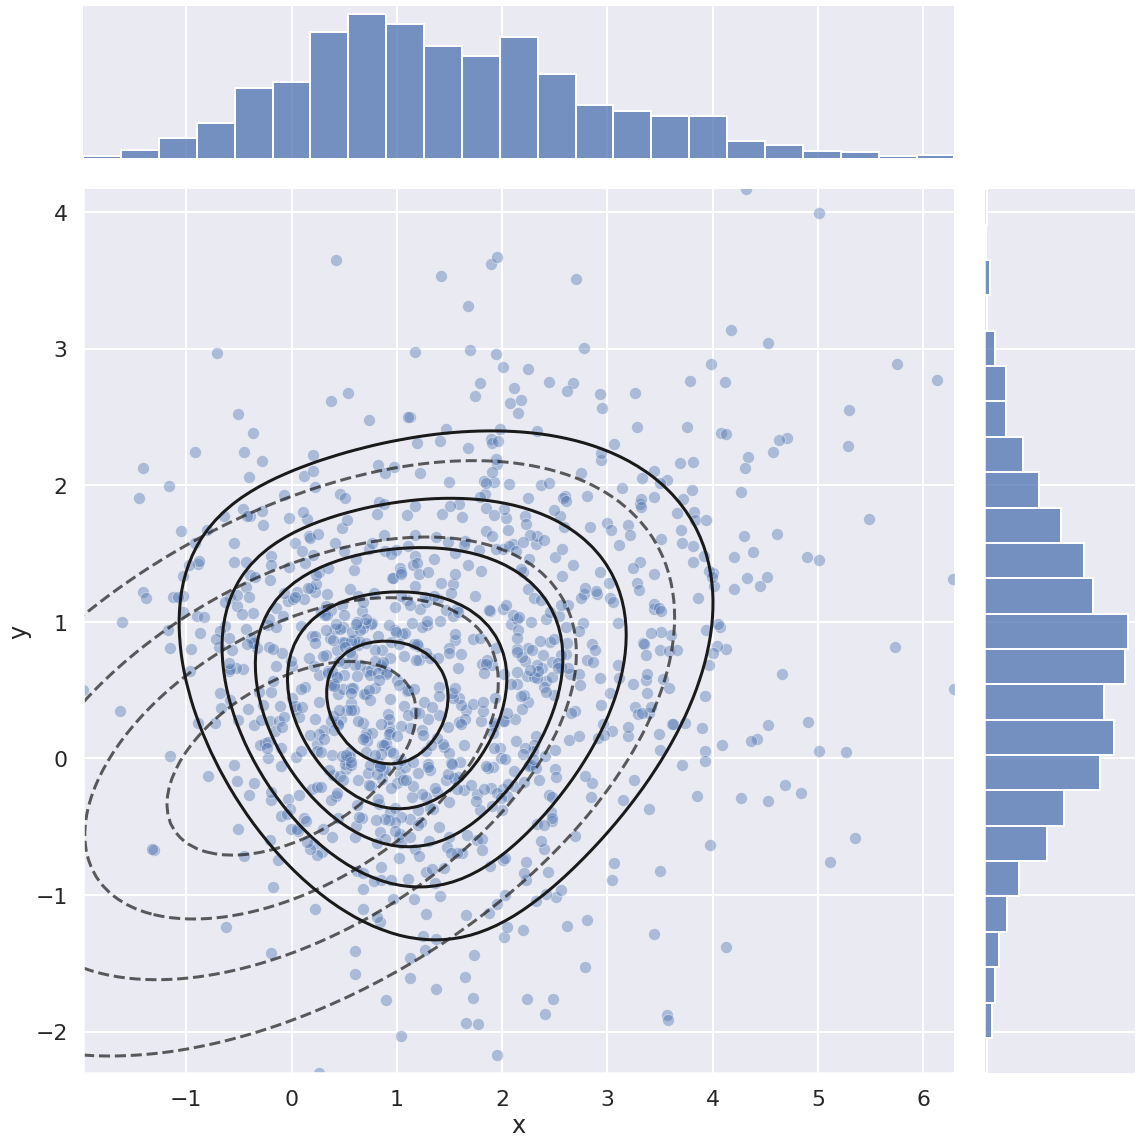

In [6]:
plot_data = pd.DataFrame(
    data,
    columns=['x', 'y']
    )
l = 100
x = jnp.linspace(jnp.min(data[:, 0]), jnp.max(data[:, 0]), l)
y = jnp.linspace(jnp.min(data[:, 1]), jnp.max(data[:, 1]), l)
xy = jnp.array(list(product(x, y)))

Z_skew = pdf_skew(xy, tcov, tslant).reshape(l, l).T
Z_norm = mvn.pdf(xy, jnp.zeros(p,), cov=tcov).reshape(l, l).T

g = sns.jointplot(data=plot_data, x='x', y='y', alpha=0.4, height=16)
g.ax_joint.contour(x, y, Z_norm, colors='k', alpha=0.7, levels=4, linestyles='dashed')
g.ax_joint.contour(x, y, Z_skew, colors='k', levels=5)
plt.show();

In [7]:
k = 0
maxit = 100

man = SPD(p=p)

optimizer = minimizer(
    man, method='rsd',
    maxiter=1, mingradnorm=tol,
    verbosity=0, logverbosity=False
    )

rng, *key = random.split(rng, 5)
sig = random.normal(key[0], shape=(p,p))
sig = jnp.matmul(sig, sig.T)

th = random.uniform(key[1], shape=(p,), maxval=10)

logl = [nloglik(sig, th)]
print(logl)

[Buffer(31860.80040701, dtype=float64)]


In [8]:
while True:
    print("Iteration {} starts from:".format(k))
    print("\tSigma : {}".format(sig.ravel()))
    print("\t(Eigs: {})".format(jnp.linalg.eigvalsh(sig)))
    print("\tTheta: {} (norm: {})".format(th, jnp.linalg.norm(th)))
    print("\tLoglik : {:.2f}".format(logl[-1]))

    loglik_sig = jit(lambda x: nloglik(x, th))
    gradient_sig = jit(grad(loglik_sig))

    res = optimizer.solve(loglik_sig, gradient_sig, x=sig)

    sig = res.x

    print('\t...')

    loglik_th = jit(lambda x: nloglik(sig, x))
    gradient_psi = jit(grad(loglik_th))

    res = minimize(loglik_th, th,
                   method="cg",
                   jac=gradient_psi,
                   tol=tol,
                   options={'maxiter':10}
                   )
    th = res.x

    logl.append(nloglik(sig, th))
    k += 1

    print("And ends at:")
    print("\tSigma : {}".format(sig.ravel()))
    print("\t(Eigs: {})".format(jnp.linalg.eigvalsh(sig)))
    print("\tTheta: {} (norm: {})".format(th, jnp.linalg.norm(th)))
    print("\tLoglik : {:.2f}".format(logl[-1]))

    if jnp.isclose(logl[-2], logl[-1], rtol=tol) or k == maxit:
        break

    if jnp.isnan(logl[-1]).any():
        print("PANIC! NAN APPEARS")
        break
    
    print("\n---\n")


Iteration 0 starts from:
	Sigma : [0.48867063 0.04752427 0.04752427 0.02829955]
	(Eigs: [0.02344479 0.49352538])
	Theta: [5.95399676 1.12798829] (norm: 6.059903879997522)
	Loglik : 31860.80
	...
And ends at:
	Sigma : [389080.5582915  317073.78926896 317073.78926896 435329.68317158]
	(Eigs: [ 94289.19909593 730121.04236715])
	Theta: [865.4105095  696.65443168] (norm: 1110.973783278624)
	Loglik : 14510.47

---

Iteration 1 starts from:
	Sigma : [389080.5582915  317073.78926896 317073.78926896 435329.68317158]
	(Eigs: [ 94289.19909593 730121.04236715])
	Theta: [865.4105095  696.65443168] (norm: 1110.973783278624)
	Loglik : 14510.47
	...
And ends at:
	Sigma : [206530.5876424  168308.86223203 168308.86223203 231081.40340902]
	(Eigs: [ 50050.08083072 387561.91022069])
	Theta: [630.51431152 507.56382199] (norm: 809.4253087386695)
	Loglik : 13877.14

---

Iteration 2 starts from:
	Sigma : [206530.5876424  168308.86223203 168308.86223203 231081.40340902]
	(Eigs: [ 50050.08083072 387561.91022069

	...
And ends at:
	Sigma : [4.18976613 1.15645671 1.15645671 1.41567237]
	(Eigs: [0.99681473 4.60862377])
	Theta: [2.83986481 1.25628905] (norm: 3.1053332063492447)
	Loglik : 3808.54

---

Iteration 21 starts from:
	Sigma : [4.18976613 1.15645671 1.15645671 1.41567237]
	(Eigs: [0.99681473 4.60862377])
	Theta: [2.83986481 1.25628905] (norm: 3.1053332063492447)
	Loglik : 3808.54
	...
And ends at:
	Sigma : [4.21578086 1.18076072 1.18076072 1.44927728]
	(Eigs: [1.01385335 4.65120479])
	Theta: [2.8486677  1.27111236] (norm: 3.1193964603668753)
	Loglik : 3808.40

---

Iteration 22 starts from:
	Sigma : [4.21578086 1.18076072 1.18076072 1.44927728]
	(Eigs: [1.01385335 4.65120479])
	Theta: [2.8486677  1.27111236] (norm: 3.1193964603668753)
	Loglik : 3808.40
	...
And ends at:
	Sigma : [4.2159309  1.18082108 1.18082108 1.44935544]
	(Eigs: [1.01390092 4.65138542])
	Theta: [2.84871838 1.27114663] (norm: 3.119456709677313)
	Loglik : 3808.40


In [11]:
def nloglik(X):
    y = jnp.concatenate([data.T, jnp.ones(shape=(1, n))], axis=0)
    datapart = jnp.trace(jnp.linalg.solve(X, jnp.matmul(y, y.T)))
    return 0.5 * (n * jnp.linalg.slogdet(X)[1] + datapart)

fun_rep = jit(nloglik)
gra_rep = jit(grad(fun_rep))

man_norm = SPD(p+1)
opt = minimizer(man_norm, method='rlbfgs', verbosity=1)
res = opt.solve(fun_rep, gra_rep, x=jnp.identity(p+1))

muhat = res.x[-1, :-1]
covhat = res.x[:-1, :-1] - jnp.outer(muhat, muhat)

Starting Riemannian Limited memory BFGS on manifold of (3 x 3) positive definite matrices
Optimization completed.
	12 iterations in 1.225 s


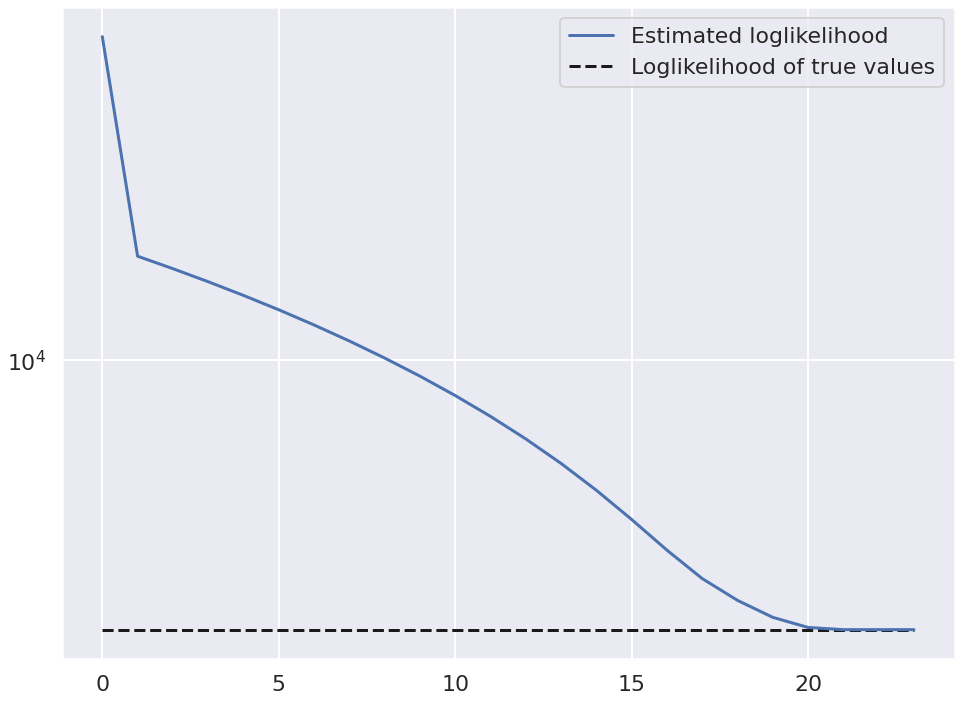

In [12]:
plt.plot(jnp.array(logl), label="Estimated loglikelihood")
plt.hlines(y=true_loglik, xmin=0, xmax=k, colors='k', linestyles='--', label="Loglikelihood of true values")
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [13]:
print("True values:")
print("\tSigma: {} (Eigs: {})".format(tcov.ravel(), jnp.linalg.eigvalsh(tcov)))
print("\tTheta: {} (norm: {})".format(tslant, jnp.linalg.norm(tslant)))
print("\tLoglik: {:.2f}".format(true_loglik))

print("Estimated values:")
print("\tSigma: {} (Eigs: {})".format(sig.ravel(), jnp.linalg.eigvalsh(sig)))
print("\tTheta: {} (norm: {})".format(th, jnp.linalg.norm(th)))
print("\tLoglik: {:.2f}".format(logl[-1]))

print("Estimated normal values:")
print("\tCovariance: {}".format(covhat.ravel()))
print("\tMean: {}".format(muhat))

True values:
	Sigma: [4.27065481 1.21378081 1.21378081 1.53117271] (Eigs: [1.07076229 4.73106523])
	Theta: [2.72181592 1.29104493] (norm: 3.0124871648569727)
	Loglik: 3809.62
Estimated values:
	Sigma: [4.2159309  1.18082108 1.18082108 1.44935544] (Eigs: [1.01390092 4.65138542])
	Theta: [2.84871838 1.27114663] (norm: 3.119456709677313)
	Loglik: 3808.40
Estimated normal values:
	Covariance: [1.98317827 0.18625879 0.18625879 1.00633833]
	Mean: [1.49424251 0.66559847]


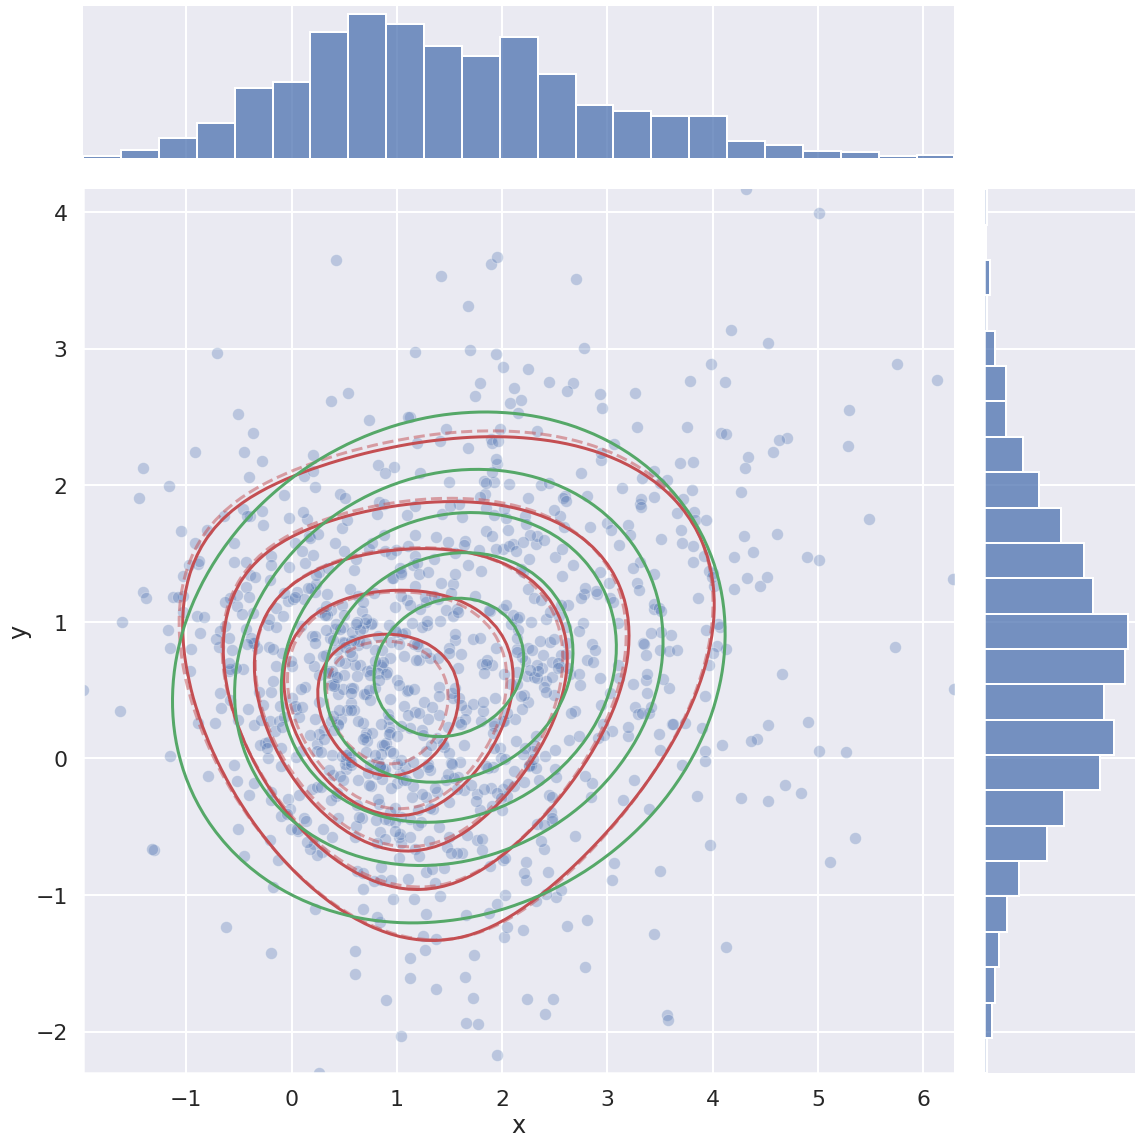

In [27]:
l = 100
x = jnp.linspace(jnp.min(data[:, 0]), jnp.max(data[:, 0]), l)
y = jnp.linspace(jnp.min(data[:, 1]), jnp.max(data[:, 1]), l)
xy = jnp.array(list(product(x, y)))
Z_est = pdf_skew(xy, sig, th).reshape(l, l).T
Z_tru = pdf_skew(xy, tcov, tslant).reshape(l, l).T
Z_norm = mvn.pdf(xy, muhat.ravel(), covhat).reshape(l, l).T

g = sns.jointplot(data=plot_data, x='x', y='y', alpha=0.3, height=16)
g.ax_joint.contour(x, y, Z_tru, colors='r', alpha=0.5, levels=5, linestyles='dashed')
g.ax_joint.contour(x, y, Z_est, colors='r', levels=5)
g.ax_joint.contour(x, y, Z_norm, colors='g', levels=5)
plt.show();

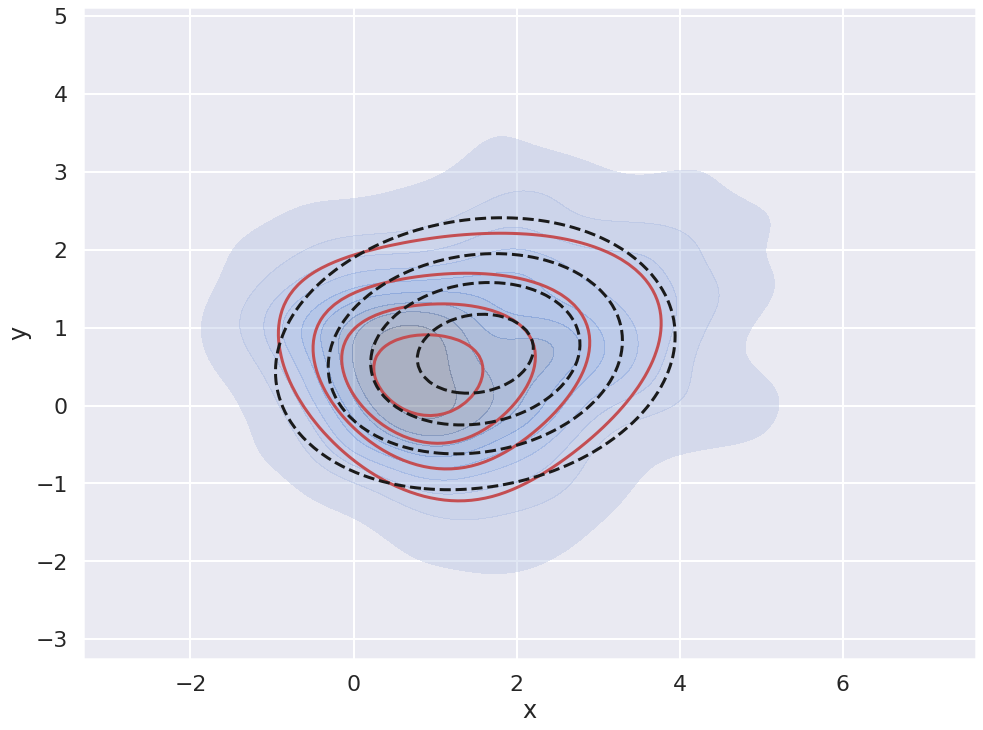

In [44]:
sns.kdeplot(data=plot_data, x='x', y='y', alpha=0.4, fill=True)
#sns.scatterplot(data=plot_data, x='x', y='y', alpha=0.3)
plt.contour(x, y, Z_est, colors='r', levels=4)
plt.contour(x, y, Z_norm, colors='k', levels=4, linestyles='dashed')
plt.show()